In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import sklearn.metrics as metrics
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.data import Dataset
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing import sequence
import gensim.downloader as api
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils import compute_class_weight
from sklearn import set_config

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
set_config(display="diagram")
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style("ticks")

In [ ]:
def build_tokenizer(texts):
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts)
    return tokenizer

def preprocess_texts(texts, tokenizer):
    text_sequences = tokenizer.texts_to_sequences(texts)
    text_sequences = tf.keras.preprocessing.sequence.pad_sequences(text_sequences)
    return text_sequences

def preprocess_labels(labels):
    characters = labels.value_counts().index
    lookup = {index:character for character,index in enumerate(characters)}
    labels = [lookup[label] for label in labels]
    return tf.keras.utils.to_categorical(labels, len(characters))

def build_vocab(tokenizer):
    word2idx = tokenizer.word_index
    idx2word = {v:k for k, v in word2idx.items()}
    word2idx["PAD"] = 0
    idx2word[0] = "PAD"
    return word2idx, idx2word

def build_datasets(text, labels):
    num_records = len(text)
    dataset = tf.data.Dataset.from_tensor_slices((text, labels))
    dataset = dataset.shuffle(num_records)
    test_size = num_records // 4
    val_size = (num_records - test_size) // 10
    test = dataset.take(test_size)
    val = dataset.skip(test_size).take(val_size)
    train = dataset.skip(test_size + val_size)
    return batch_datasets(train, test, val)

def batch_datasets(*datasets, batch_size=32):
    return (dataset.batch(batch_size, drop_remainder=True) for dataset in datasets)

def build_embedding_matrix(sequences, word2idx, embedding_dim, word_vectors):
    vocab_size = len(word2idx)
    matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2idx.items():
        try:
            matrix[idx] = word_vectors.word_vec(word)
        except KeyError: # word not in embedding
            pass
    return matrix

def get_char_lookup(characters):
    characters = characters.value_counts().index
    return {character:index for character,index in enumerate(characters)}

def get_predictions(dataset, model):
    labels, predictions = [], []
    for X_test, Y_test in dataset:
        pred = model.predict_on_batch(X_test)
        argmax_test = np.argmax(Y_test, axis=1)
        argmax_pred = np.argmax(pred, axis=1)
        labels.extend(argmax_test.tolist())
        predictions.extend(argmax_pred.tolist())
    return labels, predictions

def get_class_weights(labels):
    target_names = labels.value_counts().index.to_list()
    class_weights = compute_class_weight(class_weight='balanced', classes=target_names, y=labels)
    indexes = list(range(len(target_names)))
    return dict(zip(indexes, class_weights))

def plot_history(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 2.5)
    plt.show()

def plot_confusion_matrix(labels, predictions, target_names):
    return metrics.ConfusionMatrixDisplay.from_predictions(
        labels,
        predictions,
        cmap="Blues",
        xticks_rotation="vertical",
        display_labels=target_names
    ) 

In [ ]:
def build_model(**kwargs):
    model = Sequential()
    model.add(
        tf.keras.layers.Embedding(
            kwargs["vocab_size"], 
            kwargs["embed_size"],
            input_length=kwargs["input_length"],
            trainable=True
        )
    )
    model.add(
        tf.keras.layers.SpatialDropout1D(0.2)
    )
    model.add(
        tf.keras.layers.Conv1D(
            filters=kwargs["num_filters"],
            kernel_size=kwargs["kernel_size"],
            activation="relu"
        )
    )
    model.add(
        tf.keras.layers.GlobalMaxPooling1D()
    )
    model.add(
        tf.keras.layers.Dense(
            kwargs["output_size"],
            activation="softmax"
        )
    )
    model.build(input_shape=(None, kwargs["input_length"]))
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )
    return model

In [ ]:
def train_and_evaluate(show_name, word_vectors, epochs=20, embedding_size=300, output_size=10):
    show = pd.read_csv(f"/content/drive/MyDrive/star_trek_data/{show_name}.csv", index_col=None, engine="python").dropna()
    char_lookup = get_char_lookup(show["Character"])
    class_weights = get_class_weights(show["Character"])
    tokenizer = build_tokenizer(list(show["Lines"]))
    text_sequences = preprocess_texts(show["Lines"], tokenizer)
    cat_labels = preprocess_labels(show["Character"])
    word2idx, idx2word = build_vocab(tokenizer)
    train, test, val = build_datasets(text_sequences, cat_labels)
    embed_mat = build_embedding_matrix(text_sequences, word2idx, embedding_size, word_vectors)
    model = build_model(
        vocab_size=len(word2idx),
        embed_size=embedding_size,
        input_length=len(text_sequences[0]),
        num_filters=256,
        kernel_size=3,
        output_size=output_size,
        embed_mat=embed_mat
    )
    print(model.summary())
    history = model.fit(
        train,
        epochs=epochs,
        validation_data=val,
        class_weight=class_weights,
    )
    labels, predictions = get_predictions(test, model)
    target_names = show["Character"].value_counts().index.to_list()
    return labels, predictions, target_names, history

In [ ]:
word_vectors = api.load("glove-wiki-gigaword-300")

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**The Original Series**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 183, 300)          3219900   
                                                                 
 spatial_dropout1d (SpatialD  (None, 183, 300)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 181, 256)          230656    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 3,453,126
Trainable params: 3,453,126
Non-

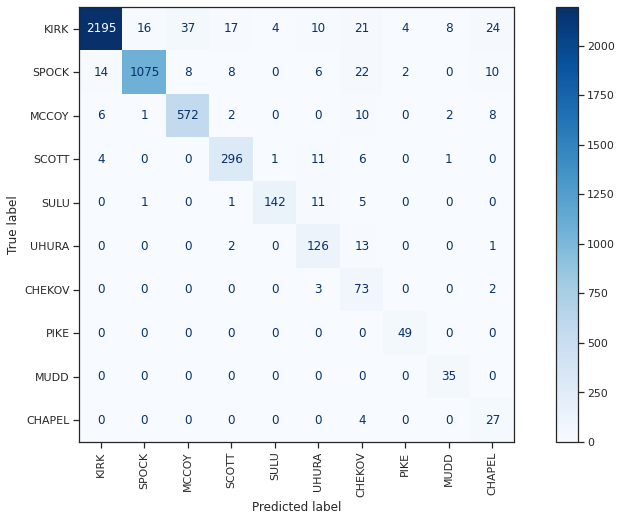

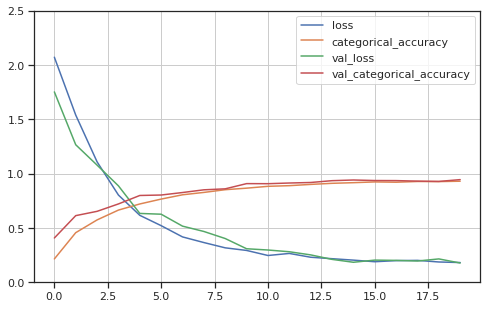

In [ ]:
labels, predictions, target_names, history = train_and_evaluate("TOS", word_vectors)
print(classification_report(labels, predictions, target_names=target_names))
print(plot_confusion_matrix(labels, predictions, target_names))
plot_history(history)

**The Next Generation**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 384, 300)          4830900   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 384, 300)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 382, 256)          230656    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 5,064,126
Trainable params: 5,064,126
No

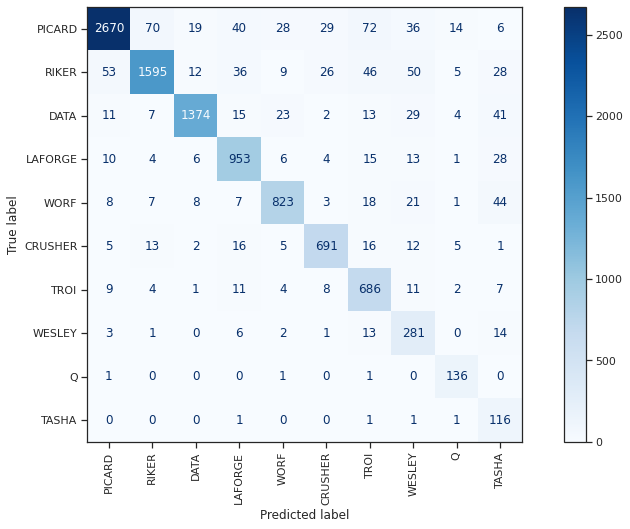

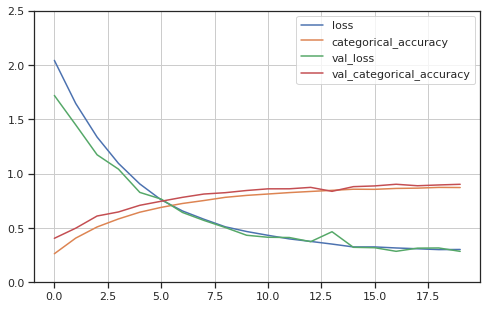

In [ ]:
labels, predictions, target_names, history = train_and_evaluate("TNG", word_vectors)
print(classification_report(labels, predictions, target_names=target_names))
print(plot_confusion_matrix(labels, predictions, target_names))
plot_history(history)

**Deep Space Nine**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          4545000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 300, 300)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 298, 256)          230656    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 4,778,226
Trainable params: 4,778,226
No

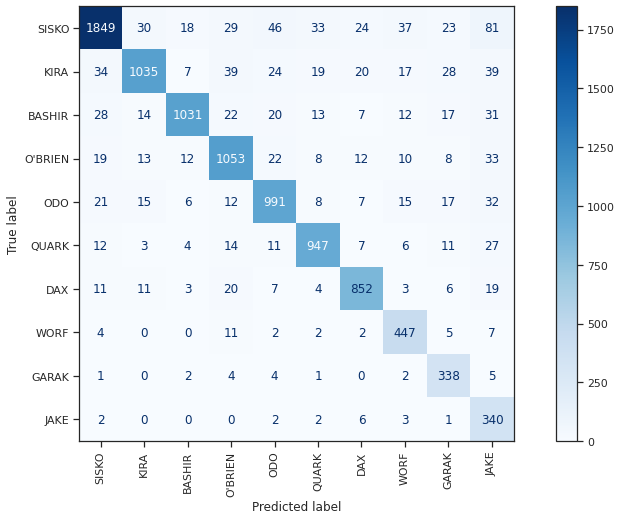

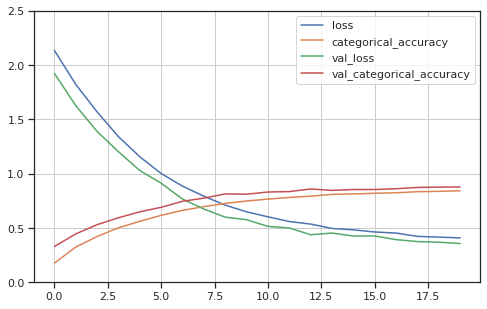

In [ ]:
labels, predictions, target_names, history = train_and_evaluate("DS9", word_vectors)
print(classification_report(labels, predictions, target_names=target_names))
print(plot_confusion_matrix(labels, predictions, target_names))
plot_history(history)

**Voyager**

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 219, 300)          5006700   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 219, 300)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_3 (Conv1D)           (None, 217, 256)          230656    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 5,239,926
Trainable params: 5,239,926
No

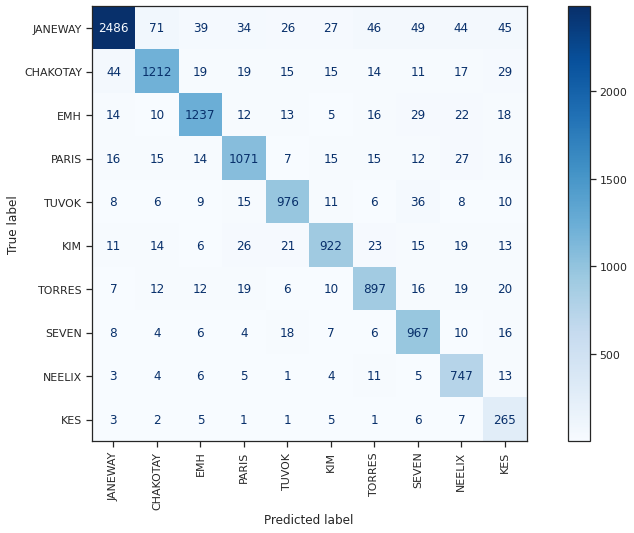

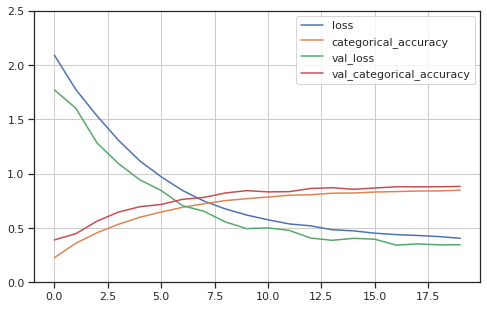

In [ ]:
labels, predictions, target_names, history = train_and_evaluate("VOY", word_vectors)
print(classification_report(labels, predictions, target_names=target_names))
print(plot_confusion_matrix(labels, predictions, target_names))
plot_history(history)

**Enterprise**

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 265, 300)          3385500   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 265, 300)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_4 (Conv1D)           (None, 263, 256)          230656    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 3,618,726
Trainable params: 3,618,726
No

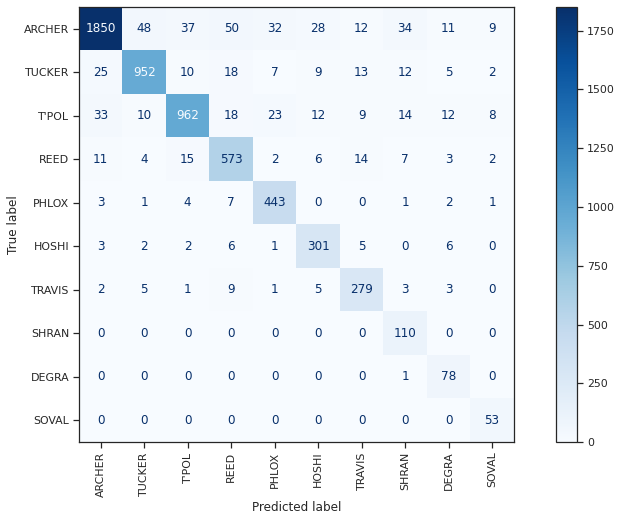

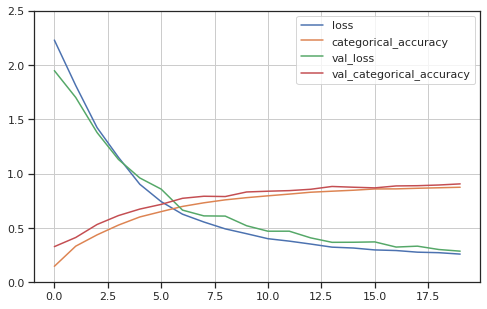

In [ ]:
labels, predictions, target_names, history = train_and_evaluate("ENT", word_vectors)
print(classification_report(labels, predictions, target_names=target_names))
print(plot_confusion_matrix(labels, predictions, target_names))
plot_history(history)

**The Animated Series**

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 93, 300)           1294200   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 93, 300)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_5 (Conv1D)           (None, 91, 256)           230656    
                                                                 
 global_max_pooling1d_5 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 1,527,426
Trainable params: 1,527,426
No

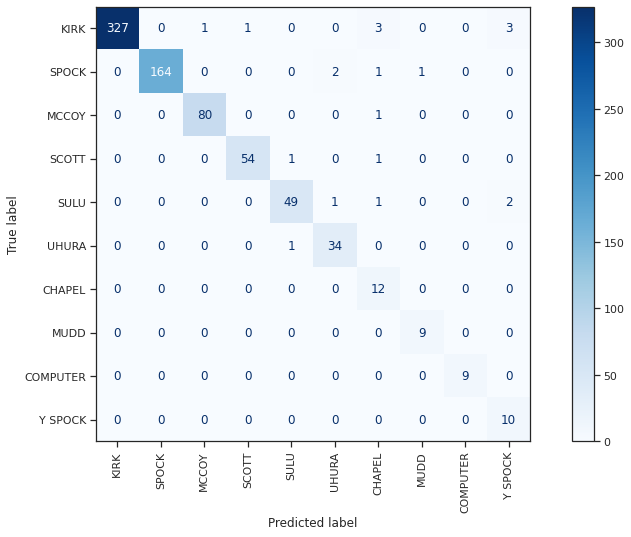

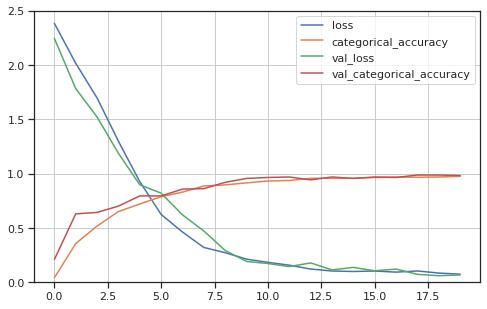

In [ ]:
labels, predictions, target_names, history = train_and_evaluate("TAS", word_vectors)
print(classification_report(labels, predictions, target_names=target_names))
print(plot_confusion_matrix(labels, predictions, target_names))
plot_history(history)